<a href="https://colab.research.google.com/github/greatermonk/Credit-Card-Fraud-Detection-Model/blob/main/Credit_Card_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Training random_forest...

Training logistic_regression...

Training xgboost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Results for random_forest:
accuracy: 0.9995
precision: 0.8710
recall: 0.8265
specificity: 0.9998
f1_score: 0.8482
roc_auc: 0.9685
pr_auc: 0.8738

Results for logistic_regression:
accuracy: 0.9741
precision: 0.0578
recall: 0.9184
specificity: 0.9742
f1_score: 0.1088
roc_auc: 0.9708
pr_auc: 0.7699

Results for xgboost:
accuracy: 0.9992
precision: 0.7281
recall: 0.8469
specificity: 0.9995
f1_score: 0.7830
roc_auc: 0.9800
pr_auc: 0.8681


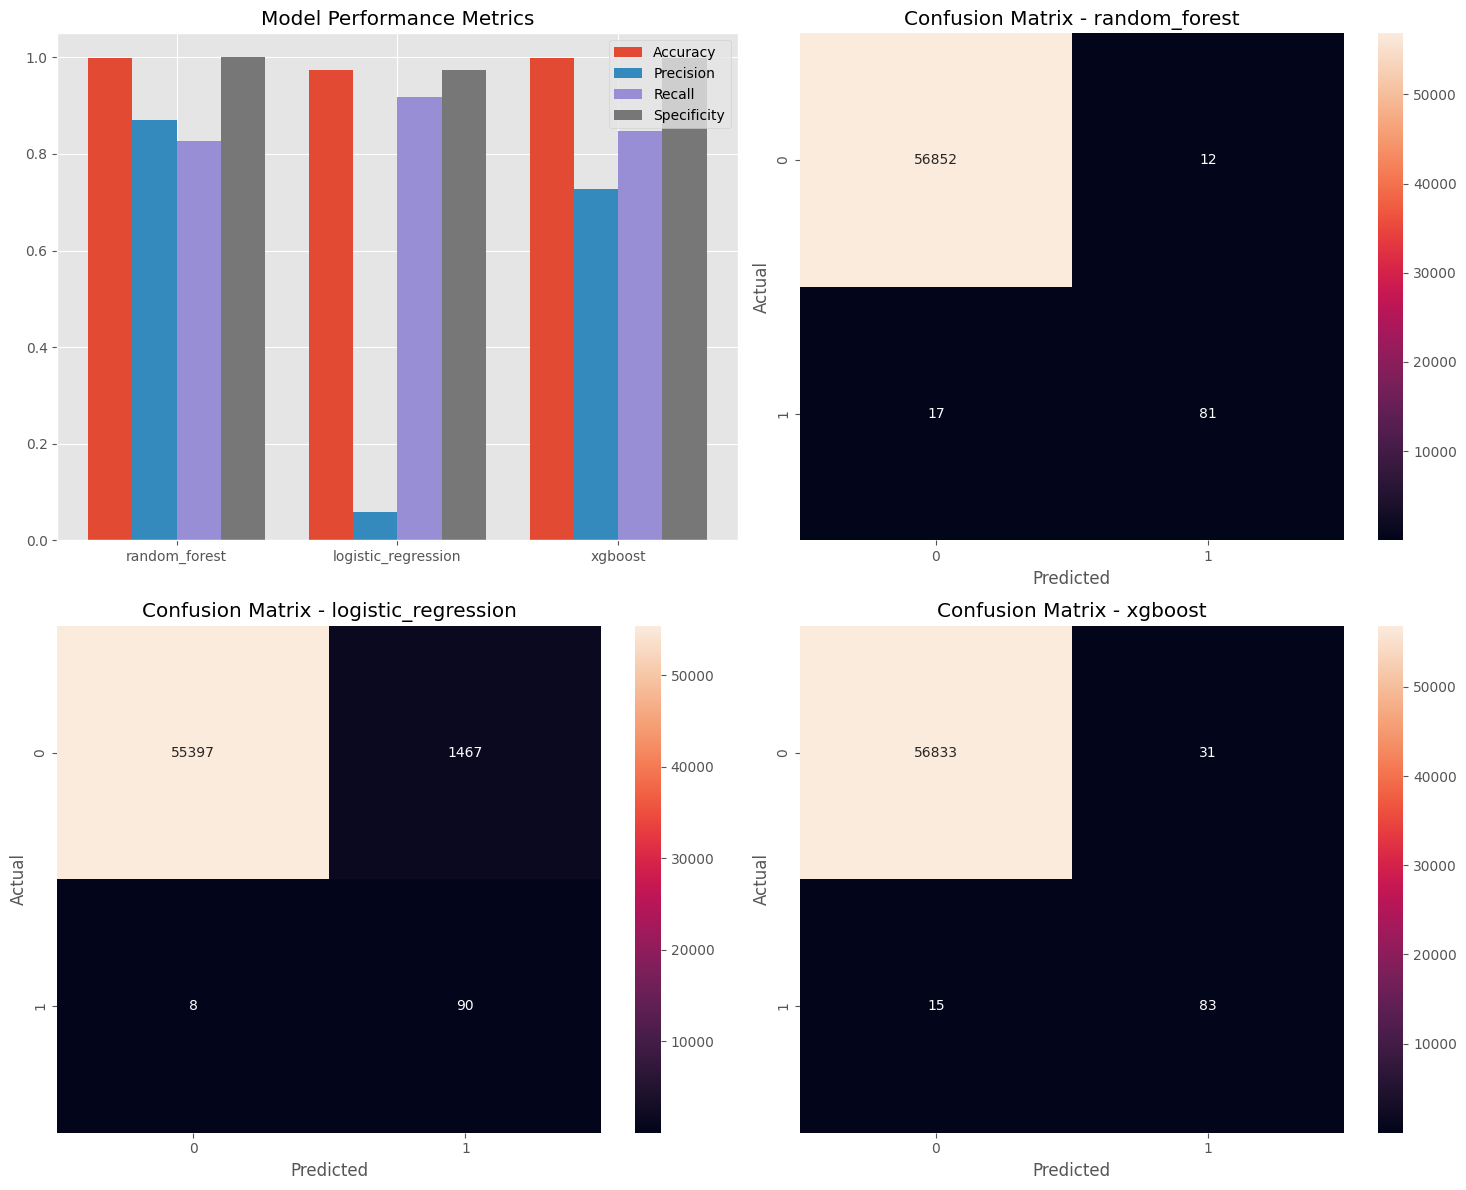

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc
!pip install --upgrade imblearn xgboost
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
raw_data = pd.read_csv('/content/drive/My Drive/Credit Card Model/creditcard.csv')


class FraudDetectionModel:
    def __init__ (self):
        self.models = {
            'random_forest': RandomForestClassifier(random_state=42, n_jobs=-1),
            'logistic_regression': LogisticRegression(random_state=42, max_iter=1000),
            'xgboost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
        }
        self.best_model = None
        self.scaler = StandardScaler()

    def load_and_preprocess (self):

        df = pd.read_csv('/content/drive/My Drive/Credit Card Model/creditcard.csv')

        # Separate features and target
        X = df.drop('Class', axis=1)
        y = df['Class']

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale the features
        self.scaler.fit(X_train)
        X_train_scaled = self.scaler.transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test

    def apply_smote (self, X_train, y_train):
        # Apply SMOTE to handle class imbalance
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        return X_train_balanced, y_train_balanced

    def train_and_evaluate (self, X_train, X_test, y_train, y_test):
        results = {}

        # Train and evaluate each model
        for name, model in self.models.items():
            print(f"\nTraining {name}...")

            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Calculate metrics
            results[name] = self.calculate_metrics(y_test, y_pred, y_pred_proba)

        # Find the best model based on F1 score
        best_model_name = max(results.items(), key=lambda x: x[1]['f1_score'])[0]
        self.best_model = self.models[best_model_name]

        return results

    def calculate_metrics (self, y_true, y_pred, y_pred_proba):
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate various metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1_score = 2 * (precision * recall) / (precision + recall)

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Calculate Precision-Recall curve and AUC
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
        pr_auc = auc(recall_curve, precision_curve)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1_score': f1_score,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'confusion_matrix': {
                'tn': tn, 'fp': fp,
                'fn': fn, 'tp': tp
            }
        }

    def plot_results(self, results):
    # Set up the plotting style
        plt.style.use('ggplot')

        # Create a figure with multiple subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Flatten the axes array for easy 1D indexing
        axes = axes.flatten()

        # Plot metrics comparison
        metrics = ['accuracy', 'precision', 'recall', 'specificity']
        model_names = list(results.keys())
        metric_values = [[results[model][metric] for model in model_names] for metric in metrics]

        # Bar plot for metrics
        ax = axes[0]
        x = np.arange(len(model_names))
        width = 0.2
        for i, metric in enumerate(metrics):
            ax.bar(x + i * width, [results[model][metric] for model in model_names],
                  width, label=metric.capitalize())
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels(model_names)
        ax.set_title('Model Performance Metrics')
        ax.legend()

        # Plot confusion matrices
        for i, (name, result) in enumerate(results.items()):
            ax = axes[i + 1]  # Start from axes[1] as axes[0] is used for metrics plot
            cm = np.array([[result['confusion_matrix']['tn'], result['confusion_matrix']['fp']],
                          [result['confusion_matrix']['fn'], result['confusion_matrix']['tp']]])
            sns.heatmap(cm, annot=True, fmt='d', ax=ax)
            ax.set_title(f'Confusion Matrix - {name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')

        plt.tight_layout()
        plt.show()




# Usage example
def main ():
    # Initialize the model
    fraud_detector = FraudDetectionModel()


    X_train, X_test, y_train, y_test = fraud_detector.load_and_preprocess()


    X_train_balanced, y_train_balanced = fraud_detector.apply_smote(X_train, y_train)


    results = fraud_detector.train_and_evaluate(X_train_balanced, X_test, y_train_balanced, y_test)


    for model_name, metrics in results.items():
        print(f"\nResults for {model_name}:")
        for metric_name, value in metrics.items():
            if metric_name != 'confusion_matrix':
                print(f"{metric_name}: {value:.4f}")

    # Plot results
    fraud_detector.plot_results(results)


if __name__ == "__main__":
    main()

# Conclusion
**Summary of Findings**

- *Logistic Regression*  has a higher true positive rate and slightly lower false negatives, which might make it preferable if catching every possible positive case (1) is critical.

- *XGBoost* has a significantly lower false positive rate, which could be preferable in scenarios where false positives (e.g., false fraud alerts) are more problematic.

**High Specificity and Low False Positives:**

- Random Forest is good at minimizing false positives, which is valuable in applications where falsely flagging legitimate transactions as fraud is costly or disruptive.


**Moderate Recall:**

 While it catches most fraud cases, it does miss a few, so if catching every fraud case is critical, further tuning may be needed, possibly with a focus on improving recall.